# K-Means Clustering

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

## Introducing K-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

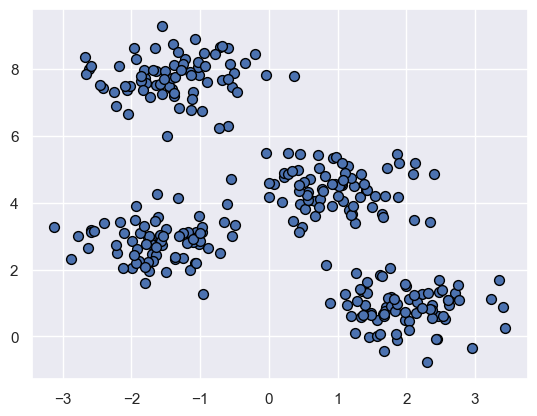

In [2]:
from sklearn.datasets import make_blobs

# Generate synthetic data
X, y_true = make_blobs(n_samples=300,       # Number of samples to generate
                       centers=4,            # Number of centers (clusters) to generate
                       cluster_std=0.60,     # Standard deviation of the clusters
                       random_state=0)       # Seed for random number generator to ensure reproducibility

# Plot the generated data
plt.scatter(X[:, 0], X[:, 1],   # Plot points with x and y coordinates
            s=50,               # Point size of 50
            edgecolor='black'); # Border color for the data point markers        

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:


In [3]:
from sklearn.cluster import KMeans

# Initialize the KMeans clustering algorithm
kmeans = KMeans(n_clusters=4)  # Number of clusters to form

# Fit the KMeans model to the data
kmeans.fit(X)  # 'X' is the data to cluster

# Predict the cluster for each sample
y_kmeans = kmeans.predict(X)  # 'y_kmeans' contains the cluster indices for each sample

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

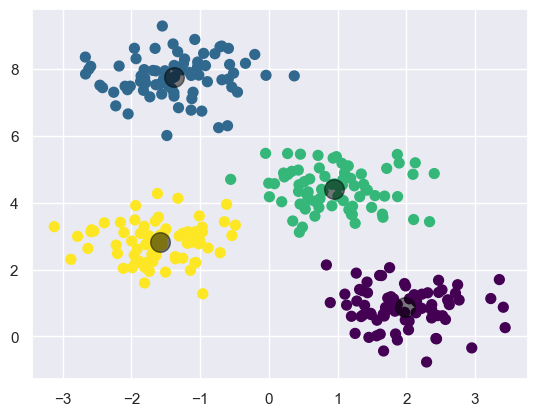

In [4]:
# Plot the data points, coloring them by their cluster assignment
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Extract the cluster centers from the KMeans model
centers = kmeans.cluster_centers_

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

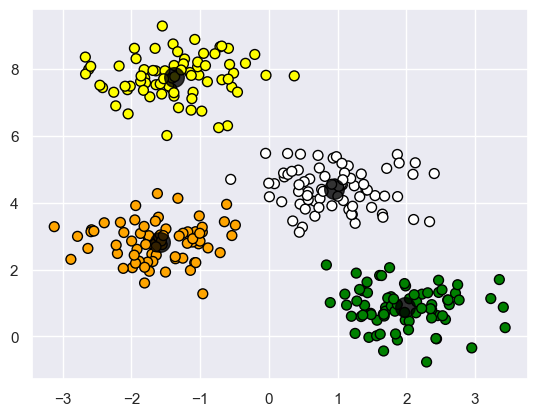

In [5]:
import matplotlib.colors as mcolors

# Define a custom colormap with a list of colors
colors = ['green', 'yellow', 'white', 'orange']
cmap_name = 'custom_black_white_vivid'        # Name for the custom colormap
custom_cmap = mcolors.ListedColormap(colors)  # Create the custom colormap

# Plot the data points, coloring them by their cluster assignment
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=custom_cmap, edgecolor='black')

# Extract the cluster centers from the KMeans model
centers = kmeans.cluster_centers_

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## K-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.

<left>
    <img src="images/05.11-expectation-maximization.PNG" width="900" />
</left>

The k-Means algorithm is simple enough that we can write it in a few lines of code. The following is a very basic implementation:

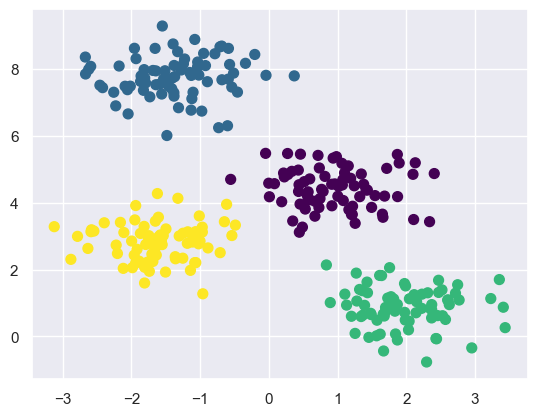

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose initial cluster centers
    rng = np.random.RandomState(rseed)            # Create a random number generator for reproducibility
    i = rng.permutation(X.shape[0])[:n_clusters]  # Randomly permute indices and select the first n_clusters as initial centers
    centers = X[i]                                # Initialize centers with the selected points
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)   # Find the index of the closest center for each data point
        
        # 2b. Update cluster centers based on the mean of assigned points
        new_centers = np.array([X[labels == i].mean(0)   # Compute the mean of points assigned to each cluster
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):   # If centers do not change, convergence is reached
            break
        centers = new_centers                # Update centers for the next iteration
    
    return centers, labels

# Find clusters and labels for the data
centers, labels = find_clusters(X, 4)

# Plot the data points with colors corresponding to their cluster labels
plt.scatter(X[:, 0], X[:, 1], c=labels,  # X and Y coordinates and cluster labels
            s=50,                        # Size of the data points
            cmap='viridis');             # Colormap to represent different clusters

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

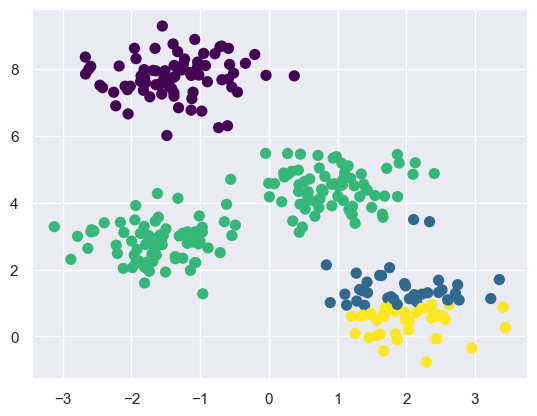

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)  # Perform clustering with 4 clusters and a random seed of 0

# Plot the data points with colors corresponding to their cluster labels
plt.scatter(X[:, 0], X[:, 1],  # X and Y coordinates of data points
            c=labels,          # Color by cluster labels
            s=50,              # Size of the data points
            cmap='viridis');   # Use 'viridis' colormap to distinguish between clusters

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

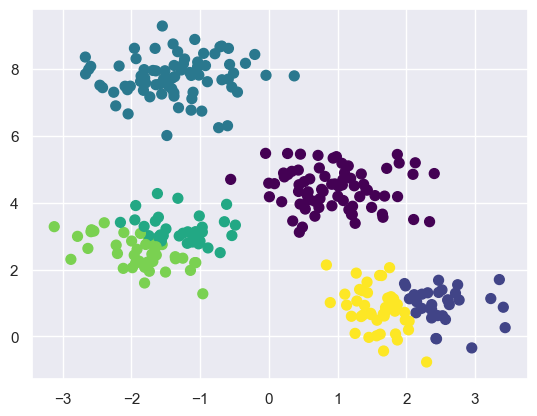

In [8]:
from sklearn.cluster import KMeans

# Perform KMeans clustering with 6 clusters and a random seed of 0
labels = KMeans(6, random_state=0).fit_predict(X)

# Plot the data points with colors corresponding to their cluster labels
plt.scatter(X[:, 0], X[:, 1],  # X and Y coordinates of data points
            c=labels,          # Color by cluster labels
            s=50,              # Size of the data points
            cmap='viridis');   # Use 'viridis' colormap to distinguish between clusters

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called silhouette analysis.

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models) or which can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the sklearn.cluster submodule).

## K-means is limited to linear cluster boundaries
The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:

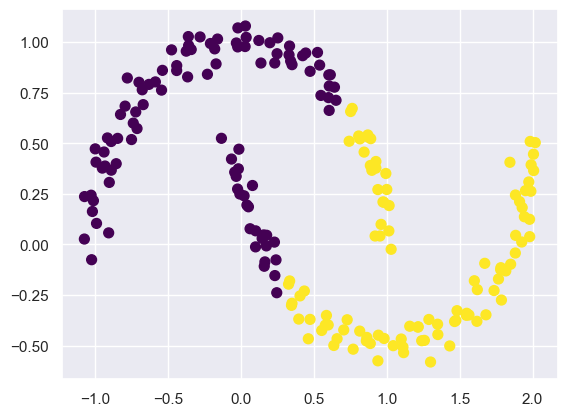

In [9]:
from sklearn.datasets import make_moons

# Generate synthetic moon-shaped data with 200 samples and a small amount of noise
X, y = make_moons(200, noise=.05, random_state=0)

# Perform KMeans clustering with 2 clusters and a random seed of 0
labels = KMeans(2, random_state=0).fit_predict(X)

# Plot the moon-shaped data points with colors corresponding to their cluster labels
plt.scatter(X[:, 0], X[:, 1],  # X and Y coordinates of data points
            c=labels,          # Color by cluster labels
            s=50,              # Size of the data points
            cmap='viridis');   # Use 'viridis' colormap to distinguish between clusters

This situation is reminiscent of the discussion in In-Depth: Support Vector Machines, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

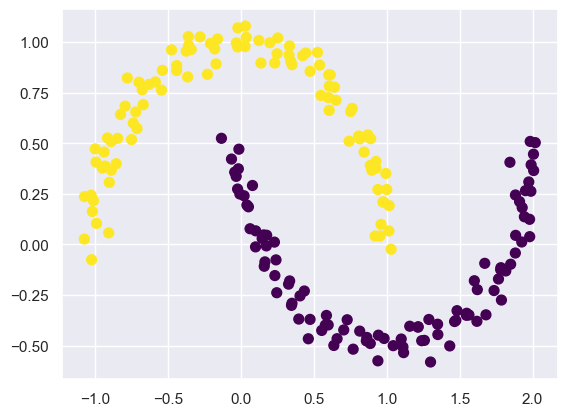

In [10]:
from sklearn.cluster import SpectralClustering

# Model SpectralClustering
model = SpectralClustering(n_clusters=2,                  # Apply Spectral Clustering with 2 clusters
                           affinity='nearest_neighbors',  # - Use 'nearest_neighbors' for computing the affinity matrix
                           assign_labels='kmeans')        # - Use 'kmeans' for assigning cluster labels

# Predict cluster labels for the data
labels = model.fit_predict(X)

# Plot the data points with colors corresponding to their cluster labels
plt.scatter(X[:, 0], X[:, 1],  # X and Y coordinates of data points
            c=labels,          # Color by cluster labels
            s=50,              # Size of the data points
            cmap='viridis');   # Use 'viridis' colormap to distinguish between clusters

We see that with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

#### K-means can be slow for large numbers of samples
Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

## Examples
Being careful about these limitations of the algorithm, we can use k-means to our advantage in a wide variety of situations. We'll now take a look at a couple examples.

### Example 1: K-means on digits
To start, let's take a look at applying k-means on the same simple digits data that we saw in Decision Trees and Random Forests and Principal Component Analysis. Here we will attempt to use k-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

We will start by loading the digits and then finding the `KMeans` clusters. Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [11]:
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Print the shape of the data array
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [12]:
from sklearn.cluster import KMeans

# Initialize KMeans with 10 clusters (one for each digit) and a fixed random seed for reproducibility
kmeans = KMeans(n_clusters=10, random_state=0)

# Fit the KMeans model to the digits data and predict cluster assignments for each sample
clusters = kmeans.fit_predict(digits.data)

# Print the shape of the cluster centers
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's see what these cluster centers look like:

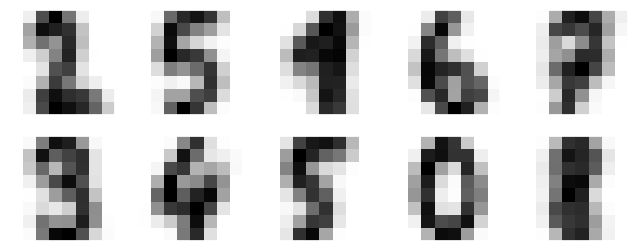

In [13]:
# Create a figure and a 2x5 grid of subplots with a specific size (8x3 inches)
fig, ax = plt.subplots(2, 5, figsize=(8, 3))

# Reshape the cluster centers to 8x8 images
# - kmeans.cluster_centers_: Array of shape (10, 64) with each row representing a cluster center
# - Reshape each center into an 8x8 image (since the original images are 8x8 pixels)
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

# Loop over each subplot and corresponding center image
for axi, center in zip(ax.flat, centers):
    
    axi.set(xticks=[], yticks=[])  # Remove x and y ticks from the subplot
    
    axi.imshow(                  # Display the center image in the subplot
        center,                  # The reshaped cluster center image
        interpolation='nearest', # Display the image without interpolation
        cmap=plt.cm.binary)      # Use a binary colormap (black and white)

We see that even without the labels, `KMeans` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [14]:
from scipy.stats import mode

# Initialize an array to store the final labels for each sample, with the same shape as clusters
labels = np.zeros_like(clusters)

# Loop over each cluster (assuming there are 10 clusters)
for i in range(10):
    # Create a boolean mask to select samples that belong to the current cluster
    mask = (clusters == i)
    
    # Compute the most frequent label (mode) for the samples in the current cluster
    # - digits.target[mask]: True labels of the samples in the current cluster
    # - mode(...)[0]: Get the most frequent label; [0] extracts the mode value from the result
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [15]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score by comparing the true labels (digits.target) with the predicted labels (labels)
# - digits.target: The true labels of the digits
# - labels: The labels assigned to each cluster, where each cluster's label is replaced by the most frequent true label in that cluster
accuracy = accuracy_score(digits.target, labels)

# Print the accuracy score
print(accuracy)

0.7440178074568725


With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let's check the confusion matrix for this:

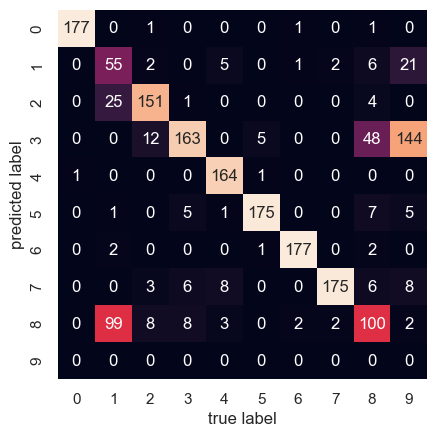

In [16]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
# - digits.target: The true labels of the digits
# - labels: The predicted labels from clustering, converted to match the true labels
mat = confusion_matrix(digits.target, labels)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(mat.T,  # Transpose the confusion matrix to align with the heatmap format
            square=True,  # Set aspect ratio to be square
            annot=True,   # Annotate each cell with its value
            fmt='d',      # Format the annotations as integers
            cbar=False,   # Do not show the color bar
            xticklabels=digits.target_names,  # Set x-axis labels to the digit names
            yticklabels=digits.target_names)  # Set y-axis labels to the digit names

# Set axis labels
plt.xlabel('true label')       # Label for the x-axis
plt.ylabel('predicted label')  # Label for the y-axis

# Display the plot
plt.show();

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [17]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Project the data into 2D using t-SNE
# t-SNE is used for dimensionality reduction, which is computationally intensive
tsne = TSNE(n_components=2,    # Reduce data to 2 dimensions for visualization
            init='random',     # Initialize the t-SNE algorithm randomly
            random_state=0)    # Seed for reproducibility
digits_proj = tsne.fit_transform(digits.data)  # Apply t-SNE to the data

# Perform clustering on the 2D projection
kmeans = KMeans(n_clusters=10,   # Number of clusters for the KMeans algorithm
                random_state=0)  # Seed for reproducibility
clusters = kmeans.fit_predict(digits_proj)  # Fit KMeans and predict cluster labels

# Permute the cluster labels to match the true labels
labels = np.zeros_like(clusters)  # Initialize an array to hold the permuted labels
for i in range(10):
    mask = (clusters == i)  # Create a mask for the current cluster
    # Assign the most common true label in the cluster to all points in the cluster
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy of the clustering by comparing the permuted labels with the true labels
accuracy = accuracy_score(digits.target, labels)  # Calculate accuracy score

# Print the accuracy score
print(accuracy)

0.9415692821368948


That's 94% classification accuracy without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

## Example 2: k-means for color compression
One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn datasets module (for this to work, you'll have to have the pillow Python package installed).

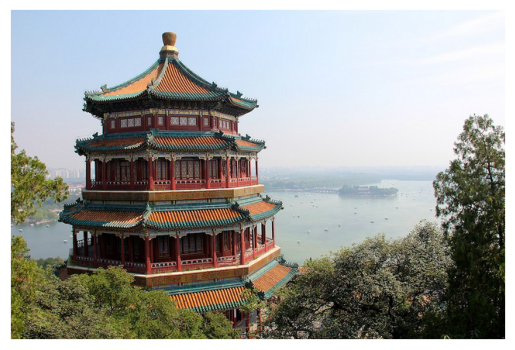

In [18]:
# Note: this requires the `pillow` package to be installed
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

# Load a sample image ("china.jpg") from scikit-learn datasets
china = load_sample_image("china.jpg")  # This function loads the image as a NumPy array

# Create a new axes object for plotting
ax = plt.axes(xticks=[], yticks=[])     # Create an axes object with no x and y ticks

# Display the image on the axes
ax.imshow(china);                       # Render the image on the axes

The image itself is stored in a three-dimensional array of size `(height, width, RGB)`, containing red/blue/green contributions as integers from 0 to 255:

In [19]:
# This returns the dimensions of the image array in the format (height, width, channels)
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to `[n_samples x n_features]`, and rescale the colors so that they lie between 0 and 1:

In [20]:
# Normalize the image data to the range 0...1
data = china / 255.0               # Divide by 255.0 to scale pixel values from 0-255 to 0-1

# Reshape the image data into a 2D array where each row represents a pixel and each column represents a color channel
data = data.reshape(427 * 640, 3)  # 427 is the height, 640 is the width, and 3 represents the RGB channels

# Check the shape of the reshaped data
data.shape                         # This should return (273280, 3), indicating 273,280 pixels and 3 color channels (RGB)

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

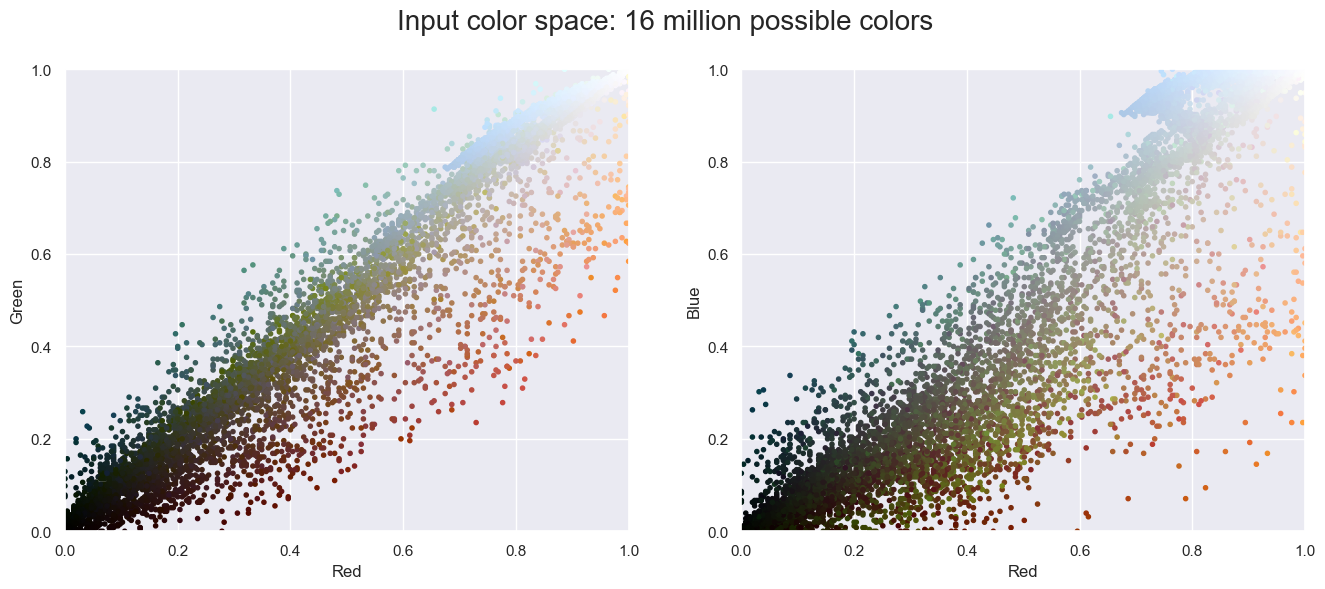

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
    # If no colors are provided, use the data itself as colors
    if colors is None:
        colors = data
    
    # Choose a random subset of data points to plot
    rng = np.random.RandomState(0)  # Set random seed for reproducibility
    i = rng.permutation(data.shape[0])[:N]  # Randomly select N data points
    colors = colors[i]  # Corresponding colors for the selected data points
    R, G, B = data[i].T  # Extract Red, Green, and Blue components
    
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot of Red vs. Green
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    
    # Scatter plot of Red vs. Blue
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    
    # Set the title for the figure
    fig.suptitle(title, size=20)


# Plot the pixel data in the RGB color space, showing the relationships between color channels
plot_pixels(
    data,     # The pixel data normalized to the 0...1 scale and reshaped into (number of pixels, 3) format
    title='Input color space: 16 million possible colors'  # Title for the plot
)

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

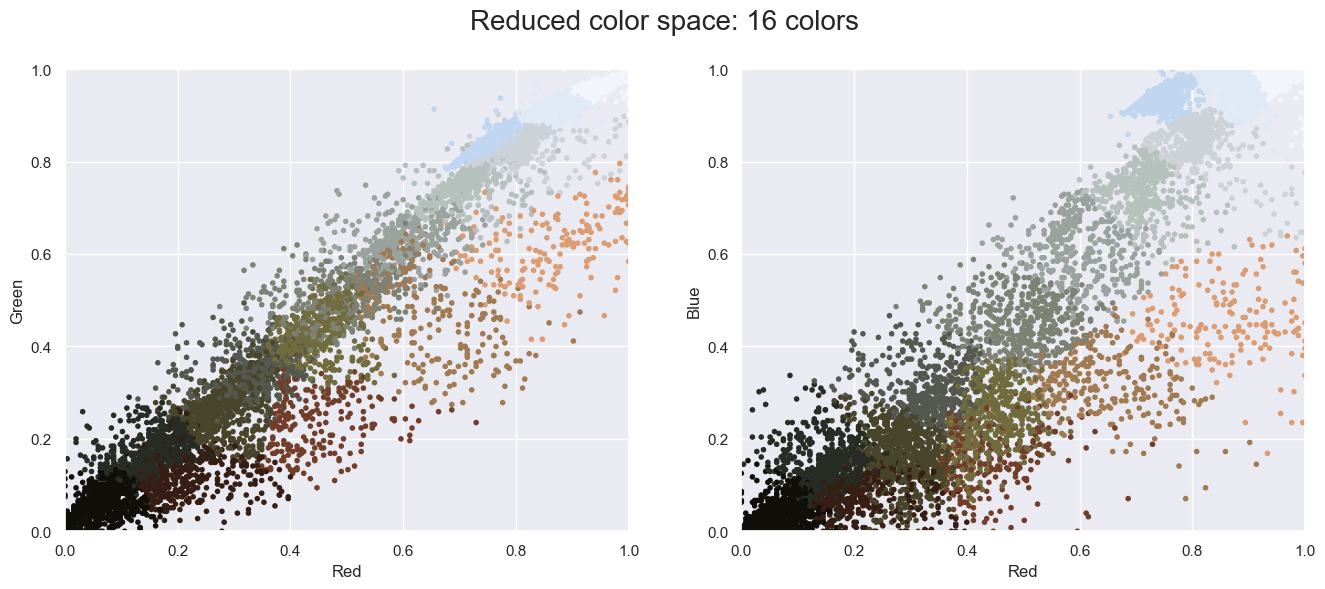

In [22]:
import warnings; warnings.simplefilter('ignore')  # Ignore warnings, e.g., NumPy-related warnings.
from sklearn.cluster import MiniBatchKMeans

# Instantiate the MiniBatchKMeans model with 16 clusters
kmeans = MiniBatchKMeans(16)

# Fit the KMeans model to the data and predict the cluster for each pixel
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Plot the pixels with the new colors, which represent the reduced color space
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

Text(0.5, 1.0, '16-color Image')

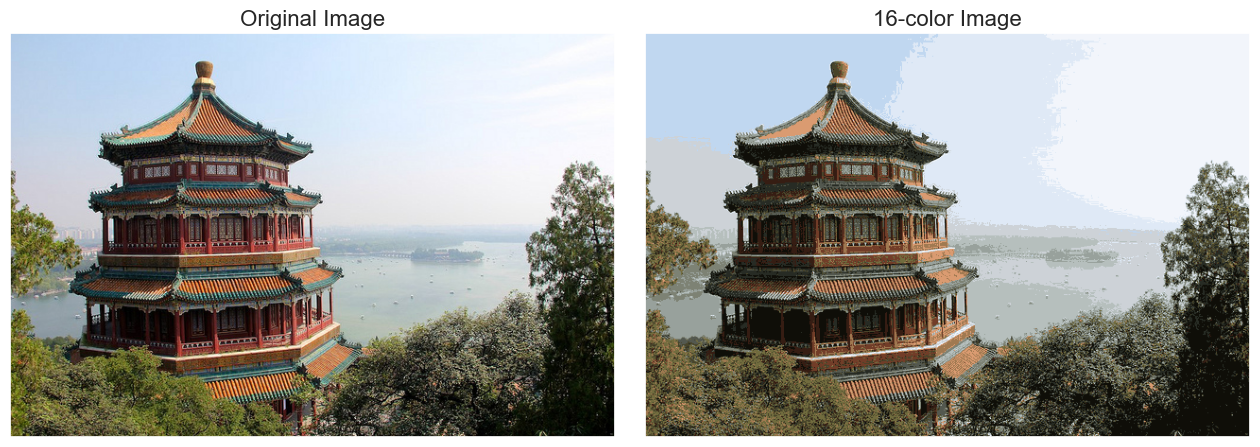

In [23]:
# Reshape the new_colors array back to the original image shape
china_recolored = new_colors.reshape(china.shape)

# Create a figure with 2 subplots to display the original and recolored images
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))  # Disable axis ticks

fig.subplots_adjust(wspace=0.05)  # Adjust space between subplots

# Display the original image in the first subplot
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)  # Set the title for the original image

# Display the 16-color recolored image in the second subplot
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)  # Set the title for the recolored image

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.

#### For 4 colors

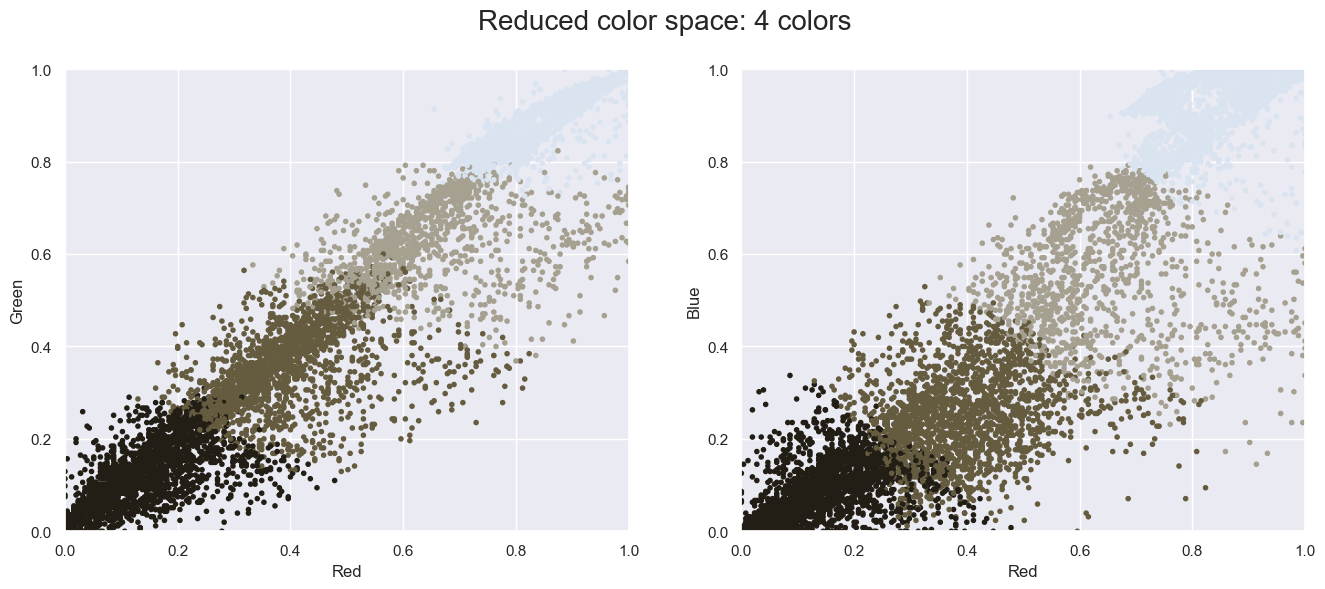

In [24]:
import warnings; warnings.simplefilter('ignore')  # Ignore warnings, e.g., NumPy-related warnings.
from sklearn.cluster import MiniBatchKMeans

# Instantiate the MiniBatchKMeans model with 16 clusters
kmeans = MiniBatchKMeans(4)

# Fit the KMeans model to the data and predict the cluster for each pixel
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Plot the pixels with the new colors, which represent the reduced color space
plot_pixels(data, colors=new_colors, title="Reduced color space: 4 colors")

Text(0.5, 1.0, '4-color Image')

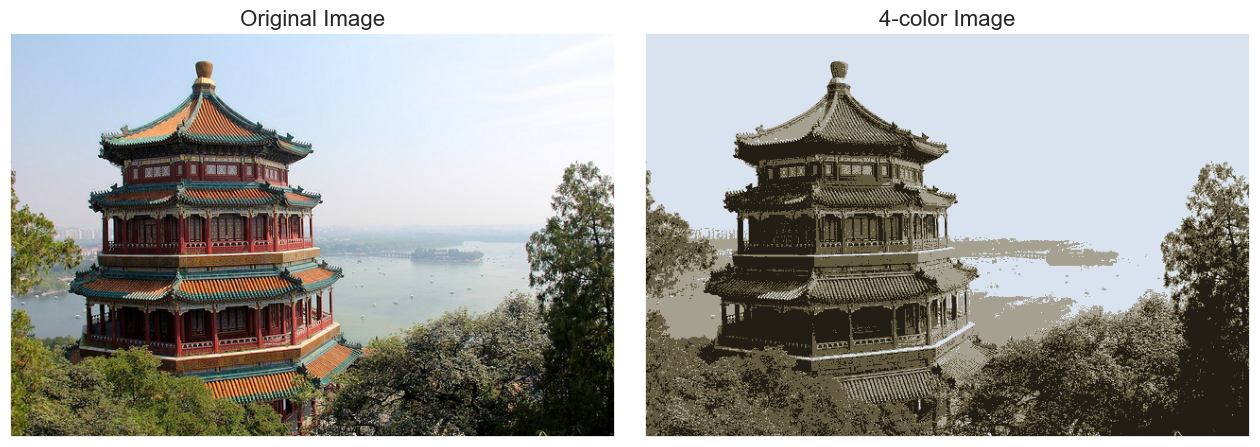

In [25]:
# Reshape the new_colors array back to the original image shape
china_recolored = new_colors.reshape(china.shape)

# Create a figure with 2 subplots to display the original and recolored images
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))  # Disable axis ticks

fig.subplots_adjust(wspace=0.05)  # Adjust space between subplots

# Display the original image in the first subplot
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)  # Set the title for the original image

# Display the 16-color recolored image in the second subplot
ax[1].imshow(china_recolored)
ax[1].set_title('4-color Image', size=16)  # Set the title for the recolored image